## Testing if median peripheral gene/ontology score is correlated across replicates

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

In [2]:
in_paths = glob.glob('../../outputs/gene_ontology/Liver?Slice?_peripheral.csv')

df = pd.DataFrame()
for in_path in in_paths:
    f_name = os.path.basename(in_path)
    sample_rep = f_name.split('_')[0]
    sample,rep = sample_rep[:6],sample_rep[6:]
    
    sub_df = pd.read_csv(in_path)
    sub_df['sample'] = sample
    sub_df['rep'] = rep
    
    df = pd.concat((df,sub_df))
    
df.head()
    

,sample_id,gene,ontology,num_cells,med_gene_spots,med_spots,med_score,score_sum,var_sum,z,p,bh_p,sample,rep
0,Liver1Slice1,Abcb4,0.0,34287,25.0,2221.0,-0.064087,-2135.588719,1431.640145,-56.441778,0.000000e+00,0.000000e+00,Liver1,Slice1
1,Liver1Slice1,Abcb4,1.0,15528,19.0,1641.0,-0.060199,-872.144345,837.348207,-30.139450,1.474750e-199,5.714074e-199,Liver1,Slice1
2,Liver1Slice1,Abcb4,2.0,6876,10.0,817.5,-0.057929,-356.874424,570.541388,-14.940731,1.790007e-50,5.718676e-50,Liver1,Slice1
3,Liver1Slice1,Abcb4,3.0,10995,12.0,944.0,-0.068404,-666.589062,807.300281,-23.460682,1.028470e-121,3.720981e-121,Liver1,Slice1
4,Liver1Slice1,Abcb4,4.0,9987,11.0,909.0,-0.065530,-590.333901,757.476187,-21.449305,4.635219e-102,1.632601e-101,Liver1,Slice1


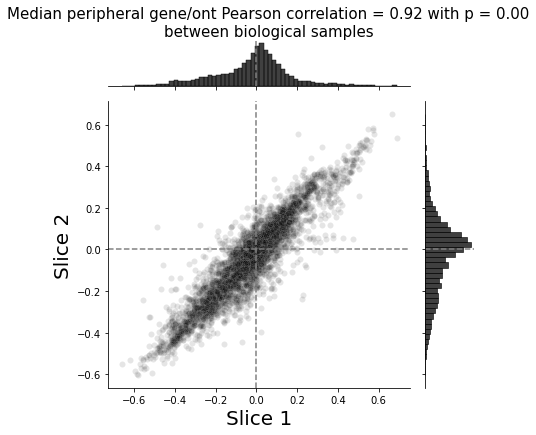

In [6]:
piv_df = df.pivot_table(
    index = ['gene','ontology'],
    columns = 'sample',
    values = 'med_score',
    aggfunc = 'median', #median of the median scores per gene/ont over both replicates
).dropna()

r,p = stats.pearsonr(piv_df['Liver1'], piv_df['Liver2'])

f = sns.jointplot(
    x = 'Liver1',
    y = 'Liver2',
    color = 'black',
    joint_kws = {'alpha':0.1},
    data = piv_df,
)
f.ax_joint.axhline(0, linestyle='dashed', color='grey')
f.ax_joint.axvline(0, linestyle='dashed', color='grey')
f.ax_marg_x.axvline(0, linestyle='dashed', color='grey')
f.ax_marg_y.axhline(0, linestyle='dashed', color='grey')

f.fig.suptitle("""Median peripheral gene/ont Pearson correlation = {:.2f} with p = {:.2f}
between biological samples
""".format(r,p), fontsize = 15)

f.fig.tight_layout()
f.fig.subplots_adjust(top=0.9)
f.ax_joint.set_xlabel('Slice 1',fontsize = 20)
f.ax_joint.set_ylabel('Slice 2',fontsize = 20)
f.savefig('vz_liver_periph_corrs_between_mice.svg')

plt.show()
plt.close()

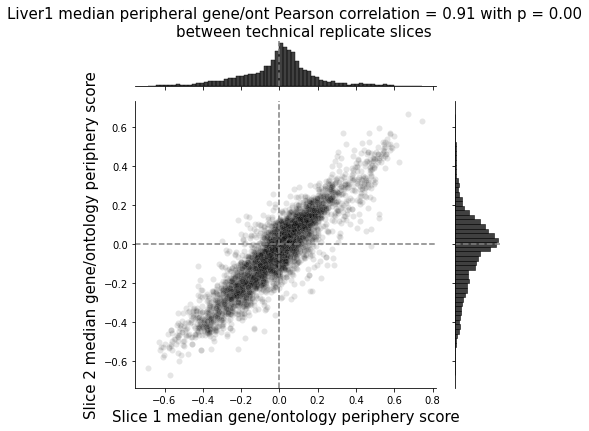

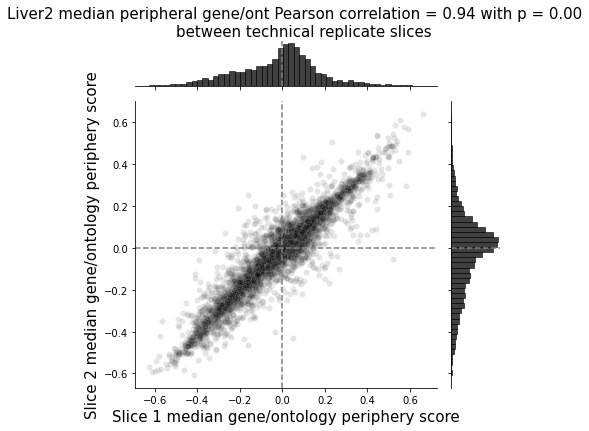

In [7]:
for sample,g in df.groupby('sample'):
    piv_g = g.pivot(
        index=['gene','ontology'],
        columns='rep',
        values = 'med_score',
    ).dropna()
    
    r,p = stats.pearsonr(piv_g['Slice1'], piv_g['Slice2'])
    
    f = sns.jointplot(
        x = 'Slice1',
        y = 'Slice2',
        color = 'black',
        joint_kws = {'alpha':0.1},
        data = piv_g,
    )
    f.ax_joint.axhline(0, linestyle='dashed', color='grey')
    f.ax_joint.axvline(0, linestyle='dashed', color='grey')
    f.ax_marg_x.axvline(0, linestyle='dashed', color='grey')
    f.ax_marg_y.axhline(0, linestyle='dashed', color='grey')
    
    f.fig.suptitle("""{} median peripheral gene/ont Pearson correlation = {:.2f} with p = {:.2f}
    between technical replicate slices
    """.format(sample,r,p),fontsize = 15)
    
    f.fig.tight_layout()
    f.fig.subplots_adjust(top=0.9)
    f.ax_joint.set_xlabel('Slice 1 median gene/ontology periphery score',fontsize = 15)
    f.ax_joint.set_ylabel('Slice 2 median gene/ontology periphery score',fontsize = 15)
    f.savefig('vz_{}_periph_corrs_between_technical_replicates.svg'.format(sample))
    
    plt.show()
    plt.close()
    
    


# Applying clusters to the filtered HDF5 files

This is slow, I'll copy it to the preprocessing directory and run it there as a job

In [21]:
import SRRS
import pandas as pd
import collections

In [2]:
#sample and cell id to cluster
cluster_anns = pd.read_csv(
    '/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/analysis/vz_Liver/vz_liver_cluster_assignments_40_neighs_10_pcs.csv',
    index_col = 0,
)
cluster_anns.index.name = 'cell_id'
cluster_anns = cluster_anns.reset_index()
ks = cluster_anns['sample']+cluster_anns['replicate']+cluster_anns['cell_id']
vs = cluster_anns['leiden']

key_to_cluster = {k:v for k,v in zip(ks,vs)}

In [9]:
#barcode id to gene name
bc_gn_df = pd.read_csv(
    '/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/preprocessing/vz_Liver_showcase_preprocessing/barcode_id_to_gene_name.txt',
    header = None,
    names = ['barcode_id','gene_name'],
)
bc_gn_df['barcode_id'] = bc_gn_df['barcode_id'].astype(str)

bc_to_gene = dict(bc_gn_df[['barcode_id','gene_name']].values)
bc_to_gene

{'0': 'Comt',
 '1': 'Ldha',
 '2': 'Pck1',
 '3': 'Akr1a1',
 '4': 'Ugt2b1',
 '5': 'Acsl5',
 '6': 'Ugt2a3',
 '7': 'Igf1',
 '8': 'Errfi1',
 '9': 'Serping1',
 '10': 'Adh4',
 '11': 'Hsd17b2',
 '12': 'Tpi1',
 '13': 'Cyp1a2',
 '14': 'Acsl1',
 '15': 'Akr1d1',
 '16': 'Alas1',
 '17': 'Aldh7a1',
 '18': 'G6pc',
 '19': 'Hsd17b12',
 '20': 'Pdhb',
 '21': 'Gpd1',
 '22': 'Cyp7b1',
 '23': 'Pgam1',
 '24': 'Hc',
 '25': 'Dld',
 '26': 'Cyp2c23',
 '27': 'Proz',
 '28': 'Acss2',
 '29': 'Psap',
 '30': 'Cald1',
 '31': 'Hsd3b3',
 '32': 'Galm',
 '33': 'Cxcl12',
 '34': 'Sardh',
 '35': 'Cebpa',
 '36': 'Aldh3a2',
 '37': 'Gck',
 '38': 'Sdc1',
 '39': 'Pdha1',
 '40': 'Npc2',
 '41': 'Hsd17b6',
 '42': 'Aqp1',
 '43': 'Adh7',
 '44': 'Smpdl3a',
 '45': 'Egfr',
 '46': 'Pgm1',
 '47': 'Fasn',
 '48': 'Ctsc',
 '49': 'Abcb4',
 '50': 'Fyb',
 '51': 'Alas2',
 '52': 'Gpi1',
 '53': 'Fech',
 '54': 'Lsr',
 '55': 'Psmd3',
 '56': 'Gm2a',
 '57': 'Pabpc1',
 '58': 'Cbr4',
 '59': 'Tkt',
 '60': 'Tmem56',
 '61': 'Eif3f',
 '62': 'Cxadr',
 '63': 'Sr

In [32]:
samples = [
    ('Liver1','Slice1','/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/inputs/filtered_out_one_gene_counts/Liver1Slice1.hdf5'),
    ('Liver1','Slice2','/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/inputs/filtered_out_one_gene_counts/Liver1Slice2.hdf5'),
    ('Liver2','Slice1','/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/inputs/filtered_out_one_gene_counts/Liver2Slice1.hdf5'),
    ('Liver2','Slice2','/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/inputs/filtered_out_one_gene_counts/Liver2Slice2.hdf5'),
]

def edit_cells(sample, liv, sli):
    for i,cell in enumerate(sample.iter_cells()):
        #change the annotation
        key = liv+sli+cell.cell_id
        cell.annotation = key_to_cluster[key]
        
        #change the gene names in multiple places
        cell.genes = list(map(bc_to_gene.get, cell.genes))
        cell.spot_genes = {z:list(map(bc_to_gene.get, genes)) for z,genes in cell.spot_genes.items()}
        cell.gene_vars = {bc_to_gene[g]:v for g,v in cell.gene_vars.items()}
        cell.gene_counts = collections.Counter({bc_to_gene[g]:v for g,v in cell.gene_counts.items()})
        
        #NOTE FOR TESTING
        if i > 1000:
            break
            
        yield cell

for liv,sli,p in samples:
    print(liv,sli,p)
    sample = SRRS.HDF5(p)
    
    cells = edit_cells(sample, liv, sli)
    SRRS.HDF5.write_cells(cells, p+'.edited')
        
    break

Liver1 Slice1 /oak/stanford/groups/horence/rob/isoform_localizations/SRRS/inputs/filtered_out_one_gene_counts/Liver1Slice1.hdf5


KeyboardInterrupt: 

In [27]:
x = SRRS.HDF5('/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/inputs/filtered_out_one_gene_counts/Liver1Slice1.hdf5.edited')
x

HDF5 /oak/stanford/groups/horence/rob/isoform_localizations/SRRS/inputs/filtered_out_one_gene_counts/Liver1Slice1.hdf5.edited

In [29]:
cells = x.cells()

In [18]:
cell.gene_counts

Counter({'219': 7,
         '16': 22,
         '13': 24,
         '14': 12,
         '3': 5,
         '0': 9,
         '8': 14,
         '9': 12,
         '120': 2,
         '128': 2,
         '148': 4,
         '70': 3,
         '62': 2,
         '45': 22,
         '38': 6,
         '34': 7,
         '36': 18,
         '35': 8,
         '28': 3,
         '24': 5,
         '27': 7,
         '33': 4,
         '6': 2,
         '1': 8,
         '12': 3,
         '205': 4,
         '210': 2,
         '270': 7,
         '11': 3,
         '46': 3,
         '53': 3,
         '49': 8,
         '47': 11,
         '86': 2,
         '98': 2,
         '117': 2,
         '155': 2,
         '88': 2,
         '137': 3,
         '21': 6,
         '30': 3,
         '26': 5,
         '60': 2,
         '55': 3,
         '57': 3,
         '84': 3,
         '7': 2,
         '37': 3,
         '39': 4,
         '99': 2,
         '15': 3,
         '5': 2,
         '32': 2,
         '52': 2,
         '185': 2,

{'0': ['Axin2',
  'Alas1',
  'Alas1',
  'Cyp1a2',
  'Cyp1a2',
  'Cyp1a2',
  'Acsl1',
  'Akr1a1',
  'Akr1a1',
  'Comt',
  'Errfi1',
  'Serping1',
  'Serping1',
  'Tfrc',
  'Sgms2',
  'Acacb',
  'Csnk1a1',
  'Cxadr',
  'Egfr',
  'Egfr',
  'Sdc1',
  'Sardh',
  'Aldh3a2',
  'Cebpa',
  'Cebpa',
  'Cebpa',
  'Acss2',
  'Acss2',
  'Hc',
  'Proz',
  'Cxcl12',
  'Ugt2a3',
  'Ldha'],
 '1': ['Serping1',
  'Tpi1',
  'Fzd8',
  'Axin2',
  'Maml1',
  'Cyp2b9',
  'Alas1',
  'Hsd17b2',
  'Cxadr',
  'Errfi1',
  'Serping1',
  'Errfi1',
  'Errfi1',
  'Cyp1a2',
  'Cyp1a2',
  'Cyp1a2',
  'Cyp1a2',
  'Cyp1a2',
  'Cyp1a2',
  'Acsl1',
  'Acsl1',
  'Acsl1',
  'Acsl1',
  'Aldh3a2',
  'Aldh3a2',
  'Sardh',
  'Aldh3a2',
  'Aldh3a2',
  'Aldh3a2',
  'Pgm1',
  'Fech',
  'Egfr',
  'Abcb4',
  'Abcb4',
  'Fasn',
  'Fasn',
  'Egfr',
  'Egfr',
  'Egfr',
  'Egfr',
  'Egfr',
  'Ldha',
  'Acacb',
  'Nrp1',
  'Minpp1',
  'Acaca',
  'Acaca',
  'Mertk',
  'H2afy',
  'Smarca4',
  'Hc',
  'Cxcl12',
  'Cxcl12',
  'Gpd1',
  'Cald1'

['Comt',
 'Ldha',
 'Hsd17b2',
 'Kdr',
 'Acaca',
 'Tpi1',
 'Tfrc',
 'Sgms2',
 'Cyp1a2',
 'Smarca4',
 'Acsl1',
 'Acacb',
 'Akr1d1',
 'Mertk',
 'Alas1',
 'G6pc',
 'Tcf7l2',
 'Fzd8',
 'Gpd1',
 'Maml1',
 'Axin2',
 'Hc',
 'Cyp2c23',
 'Proz',
 'Cyp2b9',
 'Acss2',
 'Akr1a1',
 'Cald1',
 'Galm',
 'Cxcl12',
 'Sardh',
 'Cebpa',
 'Aldh3a2',
 'Gck',
 'Sdc1',
 'Pdha1',
 'Ugt2b1',
 'Egfr',
 'Pgm1',
 'Fasn',
 'Abcb4',
 'Acsl5',
 'Gpi1',
 'Fech',
 'Psmd3',
 'Pabpc1',
 'Ugt2a3',
 'Tmem56',
 'Cxadr',
 'Gnai2',
 'Igf1',
 'Csnk1a1',
 'Errfi1',
 'Epas1',
 'Nrp1',
 'H2afy',
 'Serping1',
 'Minpp1',
 'Fgf1']

In [8]:
cell.genes

['0',
 '1',
 '11',
 '111',
 '117',
 '12',
 '120',
 '128',
 '13',
 '137',
 '14',
 '148',
 '15',
 '155',
 '16',
 '18',
 '185',
 '205',
 '21',
 '210',
 '219',
 '24',
 '26',
 '27',
 '270',
 '28',
 '3',
 '30',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '4',
 '45',
 '46',
 '47',
 '49',
 '5',
 '52',
 '53',
 '55',
 '57',
 '6',
 '60',
 '62',
 '65',
 '7',
 '70',
 '8',
 '84',
 '86',
 '88',
 '9',
 '98',
 '99']

In [5]:
cell.annotation

'100001171973967687856871852958561550684'

In [ ]:
print('hello')

In [13]:
cell.genes

['0',
 '1',
 '11',
 '111',
 '117',
 '12',
 '120',
 '128',
 '13',
 '137',
 '14',
 '148',
 '15',
 '155',
 '16',
 '18',
 '185',
 '205',
 '21',
 '210',
 '219',
 '24',
 '26',
 '27',
 '270',
 '28',
 '3',
 '30',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '4',
 '45',
 '46',
 '47',
 '49',
 '5',
 '52',
 '53',
 '55',
 '57',
 '6',
 '60',
 '62',
 '65',
 '7',
 '70',
 '8',
 '84',
 '86',
 '88',
 '9',
 '98',
 '99']

In [5]:
key_to_cluster

{'Liver1Slice110482024599960584593741782560798328923': 5,
 'Liver1Slice1111551578131181081835796893618918348842': 20,
 'Liver1Slice111173636076188568650971531877509781259': 12,
 'Liver1Slice111416753689349644427802751550871278871': 8,
 'Liver1Slice1116320174062690702928590241926360429752': 11,
 'Liver1Slice1117618209435628285601583396363416663677': 34,
 'Liver1Slice1119734422988290309520009455767728512386': 13,
 'Liver1Slice1122670796606821230326264937383221793698': 29,
 'Liver1Slice1127234768781846058678605511352431699402': 49,
 'Liver1Slice1131343870818306237824447462929184726576': 5,
 'Liver1Slice1134206186392275568276967134217212229277': 1,
 'Liver1Slice1136309033168104053230413654181249337994': 17,
 'Liver1Slice114231236083959363338955722951495138811': 32,
 'Liver1Slice1150155389371042494539577474576800115968': 5,
 'Liver1Slice1152096920599092195824086699827907094636': 6,
 'Liver1Slice1152415872385522091258639868172703840641': 11,
 'Liver1Slice1152916516438158781396672837097341898

# Applying clusters to the gene/cell outputs

Created these clusters from the code below put into a python script

Visaully found that 10 principle components seemed about right, and I upped the neighbors to 40

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

In [57]:
#Map cells to clusters and barcode_ids to genes
cluster_anns = pd.read_csv(
    '/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/analysis/vz_liver_cluster_assignments_40_neighs_10_pcs.csv',
    index_col = 0,
)
cluster_anns.index.name = 'cell_id'
cluster_anns = cluster_anns.reset_index()
ks = cluster_anns['sample']+cluster_anns['replicate']+cluster_anns['cell_id']
vs = cluster_anns['leiden']

key_to_cluster = {k:v for k,v in zip(ks,vs)}

barcode_to_gene = dict(pd.read_csv(
    '/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/preprocessing/vz_Liver_showcase_preprocessing/barcode_id_to_gene_name.txt',
    header = None,
)[[0,1]].values)

for p in glob.glob('../outputs/raw/Liver?Slice?_peripheral.csv'):
    f_name = os.path.basename(p)
    out_path = os.path.join('../outputs/gene_cell',f_name)
    sample_rep = f_name.split('_')[0]

    raw_df = pd.read_csv(p)
    raw_df['cell_key'] = sample_rep+raw_df['cell_id']
    raw_df['annotation'] = raw_df['cell_key'].map(key_to_cluster)
    raw_df['gene'] = raw_df['gene'].map(barcode_to_gene)
    raw_df = raw_df.drop(columns=['cell_key'])
    raw_df['sample_id'] = sample_rep
    
    raw_df.to_csv(out_path,index=False)
    
    print('Done with {}'.format(f_name))
    

Done with Liver1Slice1_peripheral.csv
Done with Liver2Slice1_peripheral.csv
Done with Liver2Slice2_peripheral.csv
Done with Liver1Slice2_peripheral.csv


'../outputs/gene_cell/Liver1Slice1_peripheral.csv'

In [52]:

raw_df

,metric,cell_id,annotation,num_spots,gene,num_gene_spots,median_rank,score,variance,sample_id
0,peripheral,100001171973967687856871852958561550684,12,369,Axin2,7,225.0,-0.217391,0.109894,Liver1Slice1
1,peripheral,100001171973967687856871852958561550684,12,369,Hsd17b1,1,184.0,0.005435,0.335145,Liver1Slice1
2,peripheral,100001171973967687856871852958561550684,12,369,Alas1,22,140.0,0.244565,0.037785,Liver1Slice1
3,peripheral,100001171973967687856871852958561550684,12,369,Cyp1a2,24,180.5,0.024457,0.034804,Liver1Slice1
4,peripheral,100001171973967687856871852958561550684,12,369,Acsl1,12,147.0,0.206522,0.064311,Liver1Slice1
...,...,...,...,...,...,...,...,...,...,...
95,peripheral,100001171973967687856871852958561550684,12,369,Eif3f,1,163.0,0.119565,0.335145,Liver1Slice1
96,peripheral,100001171973967687856871852958561550684,12,369,Kdr,2,205.5,-0.111413,0.167117,Liver1Slice1
97,peripheral,100001171973967687856871852958561550684,12,369,Gpr182,1,167.0,0.097826,0.335145,Liver1Slice1
98,peripheral,100001171973967687856871852958561550684,12,369,Esam,1,140.0,0.244565,0.335145,Liver1Slice1


# Inspecting cluster assignments for obvious batch effects

Are cells getting clustered by sample rather than by RNA content?

Briefly it looks like whatever batch effects are present are not too extreme since the number of cells per sample per cluster are highly correlated

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
cluster_anns = pd.read_csv(
    '/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/analysis/vz_Liver/vz_liver_cluster_assignments_40_neighs_10_pcs.csv',
    index_col = 0,
)

cluster_anns.index.name = 'cell_id'
cluster_anns.head()

,sample,replicate,leiden
cell_id,,,
10482024599960584593741782560798328923,Liver1,Slice1,5
111551578131181081835796893618918348842,Liver1,Slice1,20
11173636076188568650971531877509781259,Liver1,Slice1,12
11416753689349644427802751550871278871,Liver1,Slice1,8
116320174062690702928590241926360429752,Liver1,Slice1,11


In [10]:
#Aggregate at the cluster/sample/rep level
agg_cluster_ans = (
    cluster_anns.groupby(
        ['leiden','sample','replicate']
    ).size().reset_index(
        name='cells_per_cluster_per_sample_per_replicate'
    )
)

#Aggregate at the cluster/sample level
agg_cluster_ans['cells_per_cluster_per_sample'] = (
    agg_cluster_ans.groupby(
        ['leiden','sample']
    )['cells_per_cluster_per_sample_per_replicate'].transform('sum')
)

#Aggregate at the cluster level
agg_cluster_ans['cells_per_cluster'] = (
    agg_cluster_ans.groupby(
        ['leiden']
    )['cells_per_cluster_per_sample'].transform('sum')
)

agg_cluster_ans

,leiden,sample,replicate,cells_per_cluster_per_sample_per_replicate,cells_per_cluster_per_sample,cells_per_cluster
0,0,Liver1,Slice1,35569,50136,178660
1,0,Liver1,Slice2,14567,50136,178660
2,0,Liver2,Slice1,18948,39194,178660
3,0,Liver2,Slice2,20246,39194,178660
4,1,Liver1,Slice1,17797,29405,124976
...,...,...,...,...,...,...
385,98,Liver2,Slice2,2,4,14
386,99,Liver1,Slice1,2,3,14
387,99,Liver1,Slice2,1,3,14
388,99,Liver2,Slice1,2,4,14


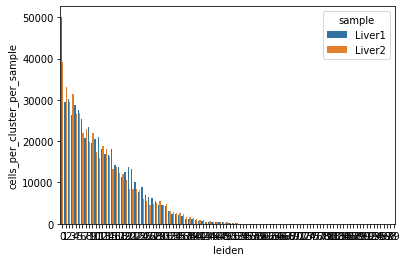

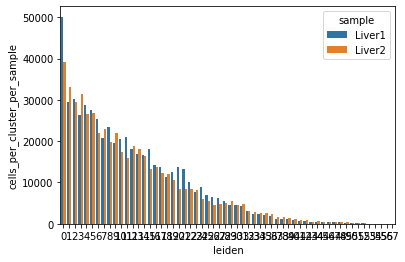

In [11]:
#Number of cells per cluster varies a lot
sns.barplot(
    x = 'leiden',
    y = 'cells_per_cluster_per_sample',
    hue = 'sample',
    data = agg_cluster_ans,
)
plt.show()
plt.close()


#Not plotting clusters with fewer than 100 cells
sns.barplot(
    x = 'leiden',
    y = 'cells_per_cluster_per_sample',
    hue = 'sample',
    data = agg_cluster_ans[agg_cluster_ans['cells_per_cluster'].ge(100)],
)
plt.show()
plt.close()


#Scatterplot of cluster cell counts
pair_df = agg_cluster_ans.pivot_table(
    index = 'leiden',
    columns = 'sample',
    values = 'cells_per_cluster_per_sample',
    aggfunc = 'first', #can use first or last, same values
)

sns.regplot(
    x = 'Liver1',
    y = 'Liver2',
    data = pair_df,
)
plt.title('Both Liver samples have similar number of cells per cluster per sample',fontsize = 15)
plt.savefig('cells_per_cluster_per_mouse.svg')
#plt.show()
plt.close()

# Clustering

Following the same clustering procedure as described by BICCN MOp MERFISH clustering

Grouping all cells from all samples together and then using off-the-shelf Leiden clustering

In [19]:
import scanpy as sc
import pandas as pd
import numpy as np
import os

import seaborn as sns
import matplotlib.pyplot as plt
import time
import h5py

cbg_paths = [
    ('Liver1','Slice1','/scratch/groups/horence/rob/data/vz_liver_showcase/Liver1Slice1/cell_by_gene.csv'),
    ('Liver1','Slice2','/scratch/groups/horence/rob/data/vz_liver_showcase/Liver1Slice2/cell_by_gene.csv'),
    ('Liver2','Slice1','/scratch/groups/horence/rob/data/vz_liver_showcase/Liver2Slice1/cell_by_gene.csv'),
    ('Liver2','Slice2','/scratch/groups/horence/rob/data/vz_liver_showcase/Liver2Slice2/cell_by_gene.csv'),
]

#neighs,pcs = 15,10 #leads to 207 clusters
neighs,pcs = 5,10 #leads to ??? clusters


df = pd.DataFrame()
samps = []
reps = []

#Read in all the data from all replicates then subset
for sample,rep_num,cbg_path in cbg_paths:
    print(cbg_path)
    cbg_df = pd.read_csv(cbg_path)

    #Subset to the cells with at least 100 spots
    cbg_df = pd.read_csv(cbg_path, index_col=0)
    spots_per_cell = cbg_df.sum(axis=1)
    keep_inds = spots_per_cell >= 100
    cbg_df = cbg_df.loc[keep_inds]

    samps += [sample]*len(cbg_df)
    reps += [rep_num]*len(cbg_df)

    df = pd.concat((df, cbg_df))

print('Size of cell-by-gene table',df.shape)
    
adata = sc.AnnData(df)
adata.obs['sample'] = samps
adata.obs['replicate'] = reps

start = time.time()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
print('Normalized',time.time()-start)

start = time.time()
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
print('Highly variable genes selected',time.time()-start)

start = time.time()
sc.tl.pca(adata, svd_solver='arpack')
print('PCA calculated',time.time()-start)

start = time.time()
sc.pp.neighbors(adata, n_neighbors=neighs, n_pcs=pcs)
print('Neighbors calculated',time.time()-start)

start = time.time()
sc.tl.leiden(adata)
print('Leiden calculated',time.time()-start)

print('Number of clusters',adata.obs['leiden'].nunique())

start = time.time()
sc.tl.umap(adata)
sc.pl.umap(adata, color=['leiden','replicate'])
print('umap calculated and plotted',time.time()-start)



/scratch/groups/horence/rob/data/vz_liver_showcase/Liver1Slice1/cell_by_gene.csv
/scratch/groups/horence/rob/data/vz_liver_showcase/Liver1Slice2/cell_by_gene.csv
/scratch/groups/horence/rob/data/vz_liver_showcase/Liver2Slice1/cell_by_gene.csv
/scratch/groups/horence/rob/data/vz_liver_showcase/Liver2Slice2/cell_by_gene.csv
Size of cell-by-gene table (1079867, 385)
Normalized 3.742011308670044
Highly variable genes selected 4.807437181472778
PCA calculated 6.469294786453247


KeyboardInterrupt: 

In [4]:
adata.obs.to_csv('cluster_assignments.csv')

,sample,replicate,leiden
10482024599960584593741782560798328923,Liver1,Slice1,2
111551578131181081835796893618918348842,Liver1,Slice1,27
11173636076188568650971531877509781259,Liver1,Slice1,9
11416753689349644427802751550871278871,Liver1,Slice1,31
116320174062690702928590241926360429752,Liver1,Slice1,8
...,...,...,...
8829987192953007550093048509424403861,Liver2,Slice2,4
8835374807117791705559879232891538925,Liver2,Slice2,0
89781679685113922121833241447564851536,Liver2,Slice2,67
92911647133981107460634270325756023502,Liver2,Slice2,8


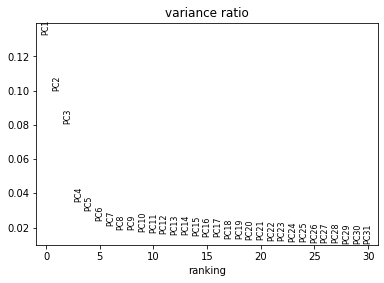

In [31]:
sc.pl.pca_variance_ratio(adata, save='pc_variance_ratios_for_clustering.svg')

... storing 'sample' as categorical
... storing 'replicate' as categorical


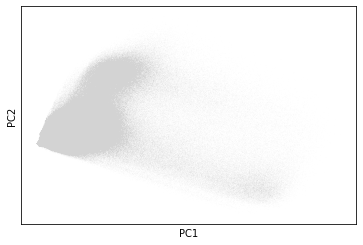

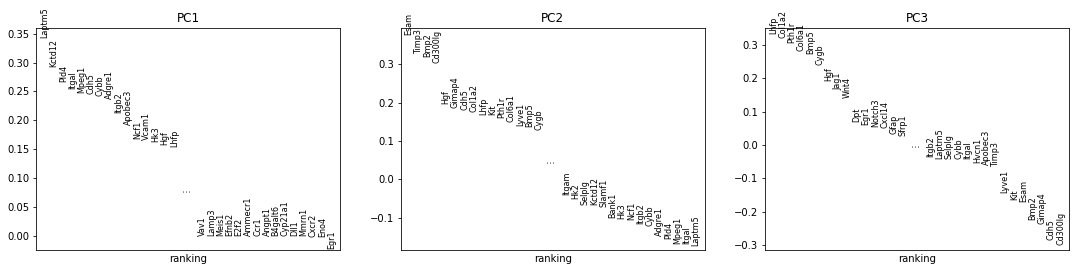

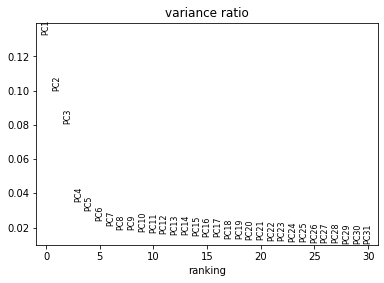

In [20]:
sc.pl.pca_overview(adata)
plt.show()
plt.close()

# Mapping barcode_id to gene name

Its in the order of the cell_by_gene header

saved this file here:
/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/preprocessing/vz_Liver_showcase_preprocessing/barcode_id_to_gene_name.txt

In [1]:
import pandas as pd
import sys
import scanpy as scp

sys.path.append('../src/')
import SRRS


In [2]:
cbg = pd.read_csv(
    '/scratch/groups/horence/rob/data/vz_liver_showcase/Liver1Slice1/cell_by_gene.csv',
    index_col = 0,
)
cbg.index.name = 'cell_id'
cbg.head()

,Comt,Ldha,Pck1,Akr1a1,Ugt2b1,Acsl5,Ugt2a3,Igf1,Errfi1,Serping1,...,Blank-28,Blank-29,Blank-30,Blank-31,Blank-32,Blank-33,Blank-34,Blank-35,Blank-36,Blank-37
cell_id,,,,,,,,,,,,,,,,,,,,,
10482024599960584593741782560798328923,8.0,6.0,96.0,5.0,8.0,1.0,8.0,6.0,25.0,28.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
111551578131181081835796893618918348842,6.0,4.0,3.0,5.0,0.0,0.0,2.0,2.0,2.0,17.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
11173636076188568650971531877509781259,5.0,5.0,30.0,3.0,1.0,0.0,4.0,2.0,11.0,11.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
11416753689349644427802751550871278871,1.0,3.0,5.0,2.0,0.0,0.0,1.0,2.0,1.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
116320174062690702928590241926360429752,33.0,19.0,11.0,12.0,0.0,4.0,19.0,13.0,19.0,41.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


In [3]:
sample = SRRS.HDF5('/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/inputs/Liver1Slice1.hdf5')
sample

HDF5 /oak/stanford/groups/horence/rob/isoform_localizations/SRRS/inputs/Liver1Slice1.hdf5

In [22]:
cells = sample.get_cells_by_id([
    '10482024599960584593741782560798328923',
    '111551578131181081835796893618918348842',
    '11173636076188568650971531877509781259',
])

for cell in cells:
    merf_gene_inds = set(cell.gene_counts.keys())
    
    cell_count = cbg.loc[cell.cell_id].reset_index(drop=True)
    gene_count_inds = set(cell_count[cell_count.gt(0)].index.astype(str))

    
    
    print(len(merf_gene_inds))
    print(len(gene_count_inds))
    print(merf_gene_inds.difference(gene_count_inds))
    
    cbg.loc[cell.cell_id]

143
143
set()
158
158
set()
105
105
set()
